In [ ]:
#a cnn for the famous cats and dogs classification challenge

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download karakaggle/kaggle-cat-vs-dog-dataset

In [ ]:
! unzip kaggle-cat-vs-dog-dataset.zip

In [ ]:
#imports
from torch.utils.data import random_split,DataLoader,Subset
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#data imports, training and test splits
transform = transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('kagglecatsanddogs_3367a/PetImages/', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_indices, test_indices = random_split(
    range(len(dataset)),
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_subset = Subset(dataset, train_indices)
loader = DataLoader(train_subset, batch_size=64, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0


for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

final_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

full_dataset = datasets.ImageFolder('kagglecatsanddogs_3367a/PetImages/', transform=final_transform)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
#model defination
class cnn(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3)
    self.b1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, kernel_size= 3)
    self.b2 = nn.BatchNorm2d(64)

    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2)
    self.b3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(3)

    self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2)
    self.b4 = nn.BatchNorm2d(256)
    self.pool4 = nn.MaxPool2d(3)

    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(1024,512)
    self.fb1 = nn.BatchNorm1d(512)

    self.fc2 = nn.Linear(512, 256)
    self.fb2 = nn.BatchNorm1d(256)

    self.d1 = nn.Dropout(0.2)

    self.fc3 = nn.Linear(256, 128)
    self.fb3 = nn.BatchNorm1d(128)

    self.fc4 = nn.Linear(128,1)

  def forward(self, X):

    out = F.relu(self.b1(self.conv1(X)))

    out = F.relu(self.b2(self.conv2(out)))

    out = F.relu(self.b3(self.conv3(out)))
    out = self.pool3(out)

    out = F.relu(self.b4(self.conv4(out)))
    out = self.pool4(out)

    out = self.flat(out)

    out = F.relu(self.fb1(self.fc1(out)))

    out = F.relu(self.fb2(self.fc2(out)))

    out = F.relu(self.fb3(self.fc3(out)))

    out = self.d1(out)

    return self.fc4(out)

#model init
model = cnn()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#hyperparameters
n_epochs = 25
learning_rate = 0.001
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

For Epoch 1: Loss = 0.53590821696849
For Epoch 2: Loss = 0.39797968252364174
For Epoch 3: Loss = 0.31713204637707915
For Epoch 4: Loss = 0.24813297610794674
For Epoch 5: Loss = 0.19573748358298884
For Epoch 6: Loss = 0.1484331359381835
For Epoch 7: Loss = 0.11640531464529819
For Epoch 8: Loss = 0.0928320963467977
For Epoch 9: Loss = 0.0847143871325272
For Epoch 10: Loss = 0.06990764463196211
For Epoch 11: Loss = 0.05827400702058675
For Epoch 12: Loss = 0.044948827210563196
For Epoch 13: Loss = 0.040052102716884884
For Epoch 14: Loss = 0.03381997505441236
For Epoch 15: Loss = 0.03981195485124488
For Epoch 16: Loss = 0.03233008380164352
For Epoch 17: Loss = 0.03503520703970753
For Epoch 18: Loss = 0.022314823418906976
For Epoch 19: Loss = 0.02802727748365387
For Epoch 20: Loss = 0.02676593518488547
For Epoch 21: Loss = 0.019643461390268027
For Epoch 22: Loss = 0.0170913088334494
For Epoch 23: Loss = 0.0246297785762145
For Epoch 24: Loss = 0.019416172661418225
For Epoch 25: Loss = 0.01902

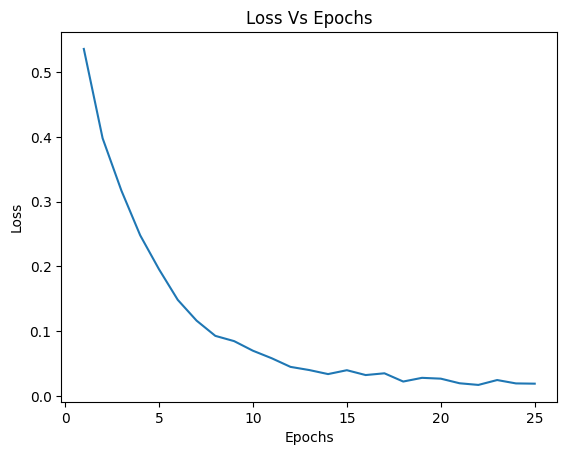

In [ ]:
#training loop
graph = {}

for epoch in range(n_epochs):

  total_loss = 0

  for batch_x, batch_y in train_loader:

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    y_hat = model(batch_x)

    l = loss(y_hat.squeeze(),batch_y.float())

    total_loss += l.item()

    l.backward()

    optimizer.step()

    optimizer.zero_grad()

  avg_loss = total_loss*(train_loader.batch_size) / len(train_loader.dataset)

  graph[epoch+1] = avg_loss

  print(f'For Epoch {epoch+1}: Loss = {avg_loss}')

plt.title('Loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(graph.keys(),graph.values())

In [ ]:
#train set accuracy
model.eval()
total_correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device).float().view(-1, 1)

        output = model(batch_x)
        probs = torch.sigmoid(output)

        predicted = (probs >= 0.5).float()
        total_correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

print(f'Training Set Accuracy: {100 * total_correct / total:.2f}%')

Training Set Accuracy: 99.42%


In [ ]:
#test set accuracy
model.eval()
total_correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device).float().view(-1, 1)

        output = model(batch_x)
        probs = torch.sigmoid(output)

        predicted = (probs >= 0.5).float()
        total_correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

print(f'Test Set Accuracy: {100 * total_correct / total:.2f}%')

Test Set Accuracy: 87.36%


In [ ]:
#it's clear that the model is overfitting. i could fix this very easily by using data augmentation and l2 regularization. if the accuracy
#drops id just make the model more deeper. unfortunately, i don't have the computational power to do this, such is life